# Customer Segmentation with K-Means

Customer segmentation is the process of organizing customers into specific groups based on shared characteristics, behaviors, or preferences, with the aim of delivering more relevant experiences.

Demographic, psychographic, behavioral and geographic segmentation are considered the four main types of market segmentation

## Import Libraries

In [368]:
#Data Analysis and Manipulation
import pandas as pd
import numpy as np
import scipy

#Data Visulization. Matplotlib is standard and Seaborn works on top of matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # for styling

#For Standardization features
from sklearn.preprocessing import StandardScaler

#sklearn's K-Means clustering algorithm
from sklearn.cluster import KMeans
# sklearn's Principal component analysis (PCA)-Linear dimensionality reduction using Singular Value Decomposition
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

## Load Data

In [370]:
# Load the data
df  = pd.read_csv("segmentation_data.csv",index_col=0)

## Explore Data

In [372]:
df.shape

(2000, 7)

In [374]:
df.head(2)

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
ID,,,,,,,
100000001,0,0,67,2,124670,1,2
100000002,1,1,22,1,150773,1,2


In [376]:
# Descriptive analysis of the data set. Here we just look at the data to gain some insight. 
# We do not apply any transformations or changes to the data.
round(df.describe(),2)

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
count,2000.00,2000.0,2000.00,2000.00,2000.00,2000.00,2000.00
mean,0.46,0.5,35.91,1.04,120954.42,0.81,0.74
std,0.50,0.5,11.72,0.60,38108.82,0.64,0.81
min,0.00,0.0,18.00,0.00,35832.00,0.00,0.00
25%,0.00,0.0,27.00,1.00,97663.25,0.00,0.00
50%,0.00,0.0,33.00,1.00,115548.50,1.00,1.00
75%,1.00,1.0,42.00,1.00,138072.25,1.00,1.00
max,1.00,1.0,76.00,3.00,309364.00,2.00,2.00


We see the mean of Age and Income 35.91 and 120954 respectively. Describe method is very useful for numerical columns.

In [378]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2000 entries, 100000001 to 100002000
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Sex              2000 non-null   int64
 1   Marital status   2000 non-null   int64
 2   Age              2000 non-null   int64
 3   Education        2000 non-null   int64
 4   Income           2000 non-null   int64
 5   Occupation       2000 non-null   int64
 6   Settlement size  2000 non-null   int64
dtypes: int64(7)
memory usage: 125.0 KB


df.info() method returns information about the DataFrame including the index data type and columns, non-null values, and memory usage.

We see that there is no missing value in the dataset and all the variables are integers.

## Correlation

A good way to get an initial understanding of the relationship between the different variables is to explore how they correlate.

We calculate the correlation between our variables using corr method in the pandas library.

In [384]:
# Compute Pearson correlation coefficient for the features in our data set.
# The correlation method in pandas, it has the Pearson correlation set as default.
df.corr()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Sex,1.000000,0.566511,-0.182885,0.244838,-0.195146,-0.202491,-0.300803
Marital status,0.566511,1.000000,-0.213178,0.374017,-0.073528,-0.029490,-0.097041
Age,-0.182885,-0.213178,1.000000,0.654605,0.340610,0.108388,0.119751
Education,0.244838,0.374017,0.654605,1.000000,0.233459,0.064524,0.034732
Income,-0.195146,-0.073528,0.340610,0.233459,1.000000,0.680357,0.490881
Occupation,-0.202491,-0.029490,0.108388,0.064524,0.680357,1.000000,0.571795
Settlement size,-0.300803,-0.097041,0.119751,0.034732,0.490881,0.571795,1.000000


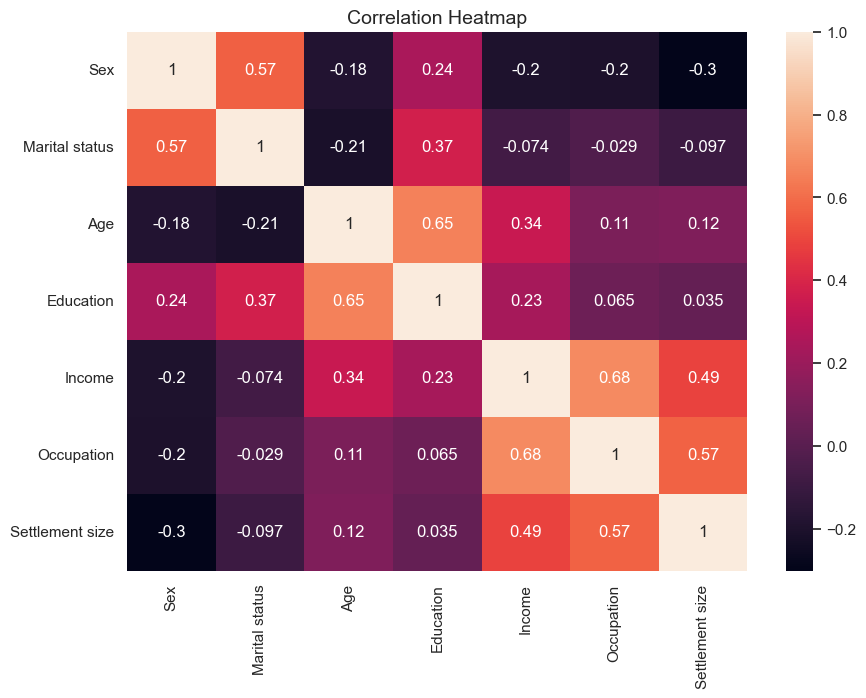

In [386]:
plt.figure(figsize=(10,7))
sns.heatmap(df.corr(), annot=True)
plt.title('Correlation Heatmap',fontsize=14)
plt.yticks(rotation =0)
plt.show()

Let’s explore the correlation.

We see that there is a strong correlation between Education and Age. In other words, older people tend to be more highly educated.

How about income and occupation?

Their correlation is 0.68. That means If you have a higher salary, you are more likely to have a higher-level occupation such as a manager.

Correlation matrix is a very useful tool to analyze the relationship between features.

## Visualize

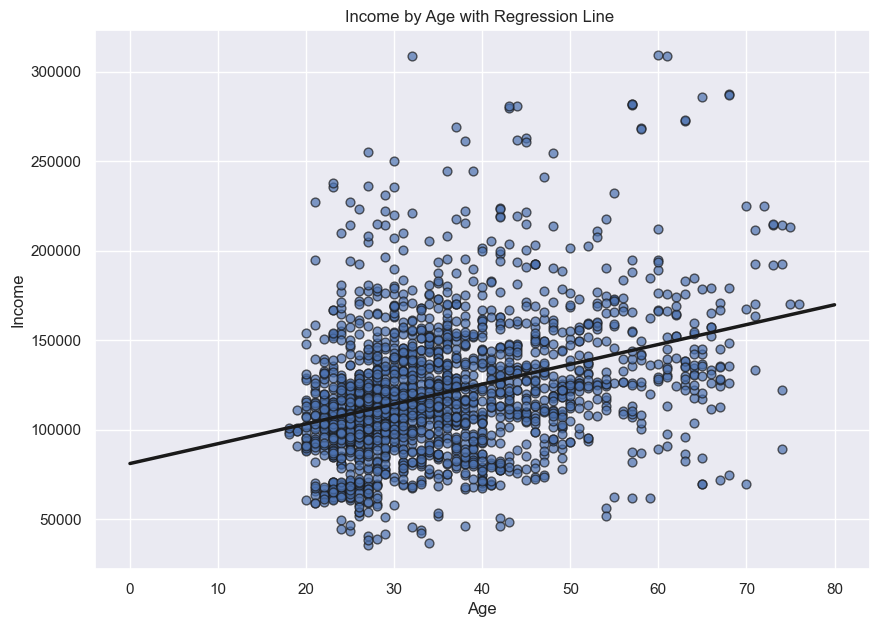

In [393]:
# Initialize layout
fig, ax = plt.subplots(figsize=(10, 7))

# Add scatterplot
x=df["Age"]
y = df["Income"]
ax.scatter(x, y, s=40, alpha=0.7, edgecolors="k")

# Fit linear regression via least squares with numpy.polyfit
# It returns an slope (b) and intercept (a)
# deg=1 means linear fit (i.e. polynomial of degree 1)
b, a = np.polyfit(x, y, deg=1)

# Create sequence of 100 numbers from 0 to 100
xseq = np.linspace(0, 80, num=100)

# # Plot regression line
ax.plot(xseq, a + b * xseq, color="k", lw=2.5)
# ax.set_xlabel='common xlabel'
# ax.ylabel='common xlabel'
ax.set(title = "Income by Age with Regression Line ", xlabel="Age", ylabel='Income')
plt.show()

As we can see as Age increases, their Income also increases.
Now, we understand our dataset and have a general idea of it.

Next section will be the segmentation. But before that, we need to scale our data first

## Data Preprocessing
We need to apply standardization to our features before using any distance-based machine learning model such as K-Means, KNN.

In general, We want to treat all the features equally and we can achieve that by transforming the features in such a way that their values fall within the same numerical range such as [0:1].

This process is commonly referred to as Standardization.

### Standardization

Standardizing data, so that all features have equal weight. This is important for modelling.
Otherwise, in our case Income would be considered much more important than Education for Instance. 
We do not know if this is the case, so we would not like to introduce it to our model. 
This is what is also refered to as bias.

In [395]:
scaler = StandardScaler()
df_std = scaler.fit_transform(df)
print(type(df_std))
df_std = pd.DataFrame(data = df_std,columns = df.columns)
df_std.head()

<class 'numpy.ndarray'>


,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,-0.917399,-0.993024,2.653614,1.604323,0.097524,0.296823,1.552326
1,1.090038,1.007025,-1.187132,-0.063372,0.782654,0.296823,1.552326
2,-0.917399,-0.993024,1.117316,-0.063372,-0.833202,-1.269525,-0.909730
3,-0.917399,-0.993024,0.775916,-0.063372,1.328386,0.296823,0.321298
4,-0.917399,-0.993024,1.458716,-0.063372,0.736932,0.296823,0.321298


### K-means Clustering

K-Means clustering is the most popular unsupervised machine learning algorithm. K-Means clustering is used to find intrinsic groups within the unlabelled dataset and draw inferences from them.  In this kernel, we segment our customers to help the marketing department for them to launch new products and sales based on the segmentation. Therefore we will save our time and money by marketing a specific group of customers with selected products.

Building Our Segmentation Model

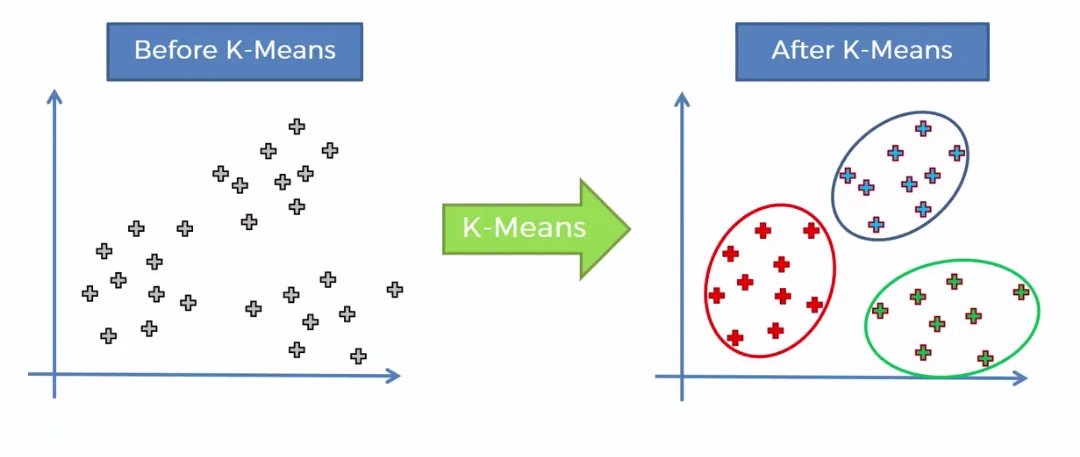

Before applying the K-Means algorithm we need to choose how many clusters we would like to have.

There are two components to choose how many clusters - Within Clusters Sum of Squares(WCSS) and Elbow Method.

In [397]:
# Perform K-means clustering. We consider 1 to 10 clusters, so our for loop runs 10 iterations.
# In addition we run the algortihm at many different starting points - k means plus plus. 
# And we set a random state for reproducibility.
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 7)
    kmeans.fit(df_std)
    wcss.append(kmeans.inertia_)

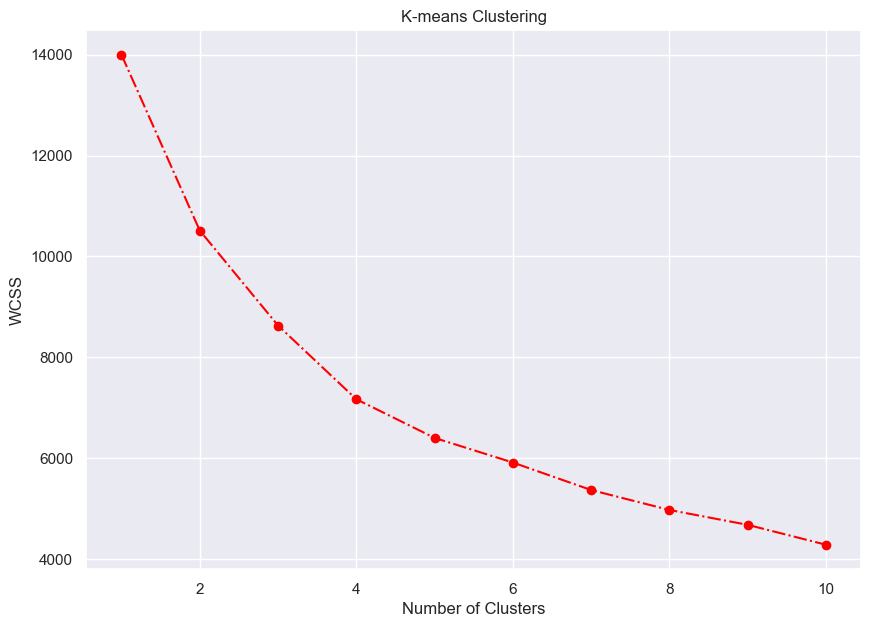

In [399]:
# Plot the Within Cluster Sum of Squares for the different number of clusters.
# From this plot we choose the number of clusters. 
# We look for a kink in the graphic, after which the descent of wcss isn't as pronounced.
plt.figure(figsize = (10,7))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '-.',color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

The elbow in the graph is the four-cluster mark. This is the only place until which the graph is steeply declining while smoothing out afterward.

Let’s perform K-Means clustering with 4 clusters.

In [401]:
# We run K-means with a fixed number of clusters. In our case 4.
kmeans = KMeans(n_clusters = 4, init = 'k-means++', random_state = 7)
# We divide our data into the four clusters.
kmeans.fit(df_std)

KMeans(n_clusters=4, random_state=7)

## Results

In [403]:
# We create a new data frame with the original features and add a new column with the assigned clusters for each point.
df_segm_kmeans= df_std.copy()
df_segm_kmeans = pd.DataFrame(data = df_std,columns = df.columns)
df_segm_kmeans['Segment K-means'] = kmeans.labels_
df_segm_kmeans.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment K-means
0,-0.917399,-0.993024,2.653614,1.604323,0.097524,0.296823,1.552326,1
1,1.090038,1.007025,-1.187132,-0.063372,0.782654,0.296823,1.552326,0
2,-0.917399,-0.993024,1.117316,-0.063372,-0.833202,-1.269525,-0.909730,2
3,-0.917399,-0.993024,0.775916,-0.063372,1.328386,0.296823,0.321298,3
4,-0.917399,-0.993024,1.458716,-0.063372,0.736932,0.296823,0.321298,3


Let’s group the customers by clusters and see the average values for each variable.

In [405]:
# Calculate mean values for the clusters
df_segm_analysis = df_segm_kmeans.groupby(['Segment K-means']).mean()
df_segm_analysis.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segment K-means,,,,,,,
0,0.796753,1.001351,-0.592830,0.050173,-0.398834,-0.276394,-0.389380
1,0.090136,0.391040,1.689452,1.819919,0.981226,0.499317,0.457039
2,-0.209147,-0.954062,-0.028257,-0.485711,-0.606168,-0.754190,-0.856438
3,-0.857528,-0.645647,-0.023378,-0.508091,0.531869,0.722760,0.964888


Since the above features mean values for the clusters are based on standardized values, they are not clear. 
So concating and getting the mean of features with the original values before standardizing.

In [408]:
df_orig_seg_ana = pd.concat([df.reset_index(drop = True), df_segm_kmeans[['Segment K-means']]], axis = 1)
df_orig_seg_ana.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment K-means
0,0,0,67,2,124670,1,2,1
1,1,1,22,1,150773,1,2,0
2,0,0,49,1,89210,0,0,2
3,0,0,45,1,171565,1,1,3
4,0,0,53,1,149031,1,1,3


In [410]:
# Calculate mean values for the clusters
df_orig_segm_analysis = df_orig_seg_ana.groupby(['Segment K-means']).mean()
df_orig_segm_analysis.sort_values(by = "Income", ascending=False, inplace=True)
df_orig_segm_analysis

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segment K-means,,,,,,,
1,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266
3,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807
0,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695
2,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290


It’s time to interpret our new dataset,

Let’s carry on with the segment(Segment 0),
This is the youngest segment with an average age of 29. They have medium level of education and average income.
They also seem average about every parameter we can label the segment average or standard.

Forth thnextst segme(Segment 1)n,

It has almost the same number of men and women with an average age of 56. Compared to other clusters, we realize that this is the oldest seg and high income.ent. econd s(Segment 2)egment, we ca say,

This segment has the lowest values for the annualsalary.

They live almost exclusively in smll cities

With low income living in small cities, it seems that this is a segment of people with fewer oerage or standard.

Finally, we come t(Segment 3)othe fourth segment,

It is comprised almost entirely of men, less than 20 percent of whomare in relationships.

Looking at the numbers, we observe relatively low values for education, paired with high values fo income and occupation.

The majority of this segment lives in big or middle-sized cities.

Let’s label the segment according to their relevance.

In [413]:
df_orig_segm_analysis.rename({0:'young&standard',
                         1:'old&rich',
                         2:'midage&fewer_opportunities',
                         3:'midage&career_focused'})

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Segment K-means,,,,,,,
old&rich,0.501901,0.692015,55.703422,2.129278,158338.422053,1.129278,1.110266
midage&career_focused,0.029825,0.173684,35.635088,0.733333,141218.249123,1.271930,1.522807
young&standard,0.853901,0.997163,28.963121,1.068085,105759.119149,0.634043,0.422695
midage&fewer_opportunities,0.352814,0.019481,35.577922,0.746753,97859.852814,0.329004,0.043290


In [415]:
labels_dict =  {0:'young&standard',
                         1:'old&rich',
                         2:'midage&fewer_opportunities',
                         3:'midage&career_focused'}

In [417]:
# Add the segment labels to our table
df_segm_kmeans['Labels'] = df_segm_kmeans['Segment K-means'].map(labels_dict)

In [419]:
df_segm_kmeans.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Segment K-means,Labels
0,-0.917399,-0.993024,2.653614,1.604323,0.097524,0.296823,1.552326,1,old&rich
1,1.090038,1.007025,-1.187132,-0.063372,0.782654,0.296823,1.552326,0,young&standard
2,-0.917399,-0.993024,1.117316,-0.063372,-0.833202,-1.269525,-0.909730,2,midage&fewer_opportunities
3,-0.917399,-0.993024,0.775916,-0.063372,1.328386,0.296823,0.321298,3,midage&career_focused
4,-0.917399,-0.993024,1.458716,-0.063372,0.736932,0.296823,0.321298,3,midage&career_focused


Finally, we can create our plot to visualize each segment.

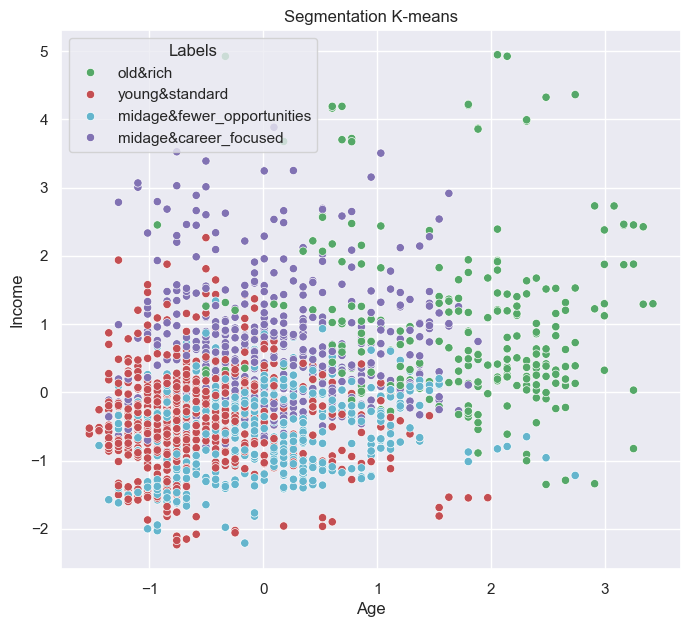

In [421]:
# We plot the results from the K-means algorithm. 
# Each point in our data set is plotted with the color of the clusters it has been assigned to.
x = df_segm_kmeans['Age']
y = df_segm_kmeans['Income']
plt.figure(figsize = (8, 7))
sns.scatterplot(data=df_segm_kmeans,x=x, y=y, hue = df_segm_kmeans['Labels'], palette = ['g', 'r', 'c', 'm'])
plt.title('Segmentation K-means')
plt.show()

We can see the green segment well off is clearly separated as it is highest in both age and income. But the other three are grouped together.

We can conclude that K-Means did a decent job! However, it’s hard to separate segments from each other.Wn, we will combine PCA and K-Means to try to get a better result.
###
Apply dimensionality reduction to simplify our problem.

We will choose reasonable components in order to obtain a better clustering solution than with the standard K-Means. So that We aim to see a nice and clear plot for our segmented groups. PCA

In [424]:
# Employ PCA to find a subset of components, which explain the variance in the data.
pca = PCA()
# Fit PCA with our standardized data.
pca.fit(df_std)
# The attribute shows how much variance is explained by each of the seven individual components.
pca.explained_variance_ratio_

array([0.35696328, 0.26250923, 0.18821114, 0.0755775 , 0.05716512,
       0.03954794, 0.02002579])

We observe that the first component explains around 36 % of the variability of the data. The second one is 26 % and so on.

We now can plot the cumulative sum of explained variance.

Text(0, 0.5, 'Cumulative Explained Variance')

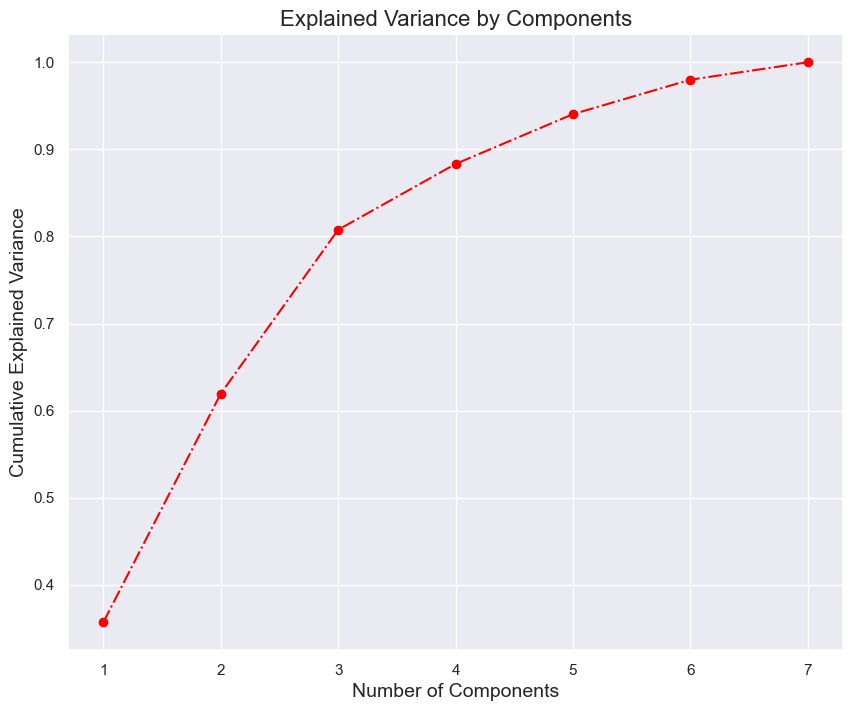

In [429]:
# On this graph we choose the subset of components we want to keep. 
# Generally, we want to keep around 80 % of the explained variance.
plt.figure(figsize = (10,8))
plt.plot(range(1,8), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '-.',color='red')
plt.title('Explained Variance by Components',fontsize=16)
plt.xlabel('Number of Components',fontsize=14)
plt.ylabel('Cumulative Explained Variance',fontsize=14)

Well, How do we choose the right number of components? The answer is there is no right or wrong answer for that.

But, a rule of thumb is to keep at least 70 to 80 percent of the explained variance.

80 % of the variance of the data is explained by the first 3 components. Let’s keep the first 3 components for our further analysis.


In [432]:
# We choose three components. 3 or 4 seems the right choice according to the previous graph.
pca = PCA(n_components = 3)
#Fit the model the our data with the selected number of components. In our case three.
pca.fit(df_std)

PCA(n_components=3)

### PCA Results

In [434]:
# Here we discucss the results from the PCA.
# The components attribute shows the loadings of each component on each of the seven original features.
# The loadings are the correlations between the components and the original features. 
pca.components_

array([[-0.31469524, -0.19170439,  0.32609979,  0.15684089,  0.52452463,
         0.49205868,  0.46478852],
       [ 0.45800608,  0.51263492,  0.31220793,  0.63980683,  0.12468314,
         0.01465779, -0.06963165],
       [-0.29301261, -0.44197739,  0.60954372,  0.27560461, -0.16566231,
        -0.39550539, -0.29568503]])

The result is a 3 by 7 array. We reduced our futures to three components from the original seven values that explain the shape the values themselves show the so-called loadings.
Loadings are correlations between an original variable and the component.
For instance, the first value of the array shows the loading of the first feature on the first component.
Let’s put this information in a pandas data frame so that we can see them nicely. Columns are seven original features and rows are three components that PCA gave us.

In [439]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = df.columns,
                           index = ['Component 1', 'Component 2', 'Component 3'])
df_pca_comp

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Component 1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
Component 2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
Component 3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685


In [441]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = df.columns,
                           index = ['Component 1', 'Component 2', 'Component 3'])
df_pca_comp

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
Component 1,-0.314695,-0.191704,0.326100,0.156841,0.524525,0.492059,0.464789
Component 2,0.458006,0.512635,0.312208,0.639807,0.124683,0.014658,-0.069632
Component 3,-0.293013,-0.441977,0.609544,0.275605,-0.165662,-0.395505,-0.295685


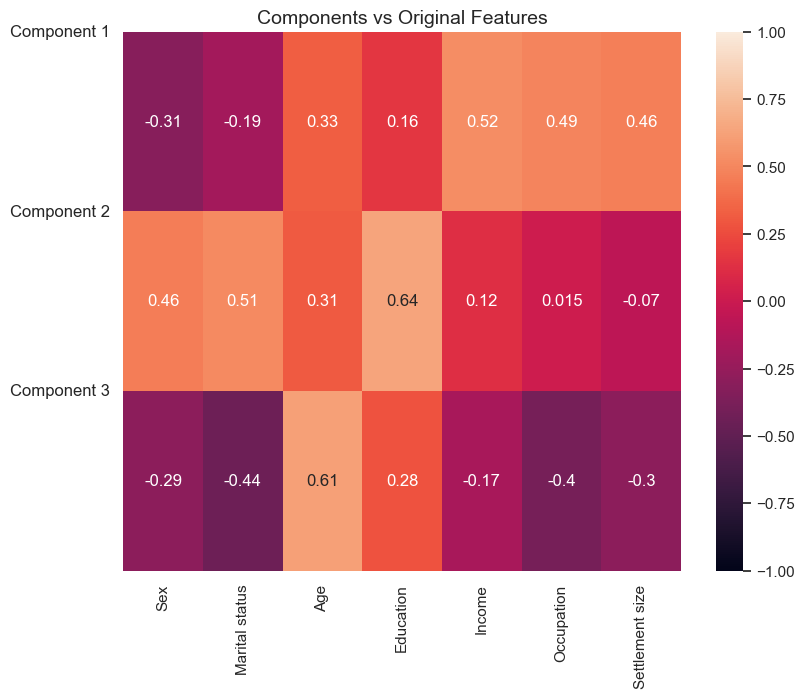

In [445]:
# Heat Map for Principal Components against original features. Again we use the RdBu color scheme and set borders to -1 and 1.
plt.figure(figsize=(9,7))
sns.heatmap(df_pca_comp,
            vmin = -1, 
            vmax = 1,
            #cmap = 'RdBu',
            annot = True)
plt.yticks([0, 1, 2], 
           ['Component 1', 'Component 2', 'Component 3'],
           rotation = 0,
           fontsize = 12)
plt.title('Components vs Original Features',fontsize = 14)
plt.show()

We see that there is a positive correlation between Component1 and Age,Income, Occupation and Settlement size. These are strictly related to the career of a person. So this component shows the career focus of the individual.

For the second component Sex, Marital status and Education are by far the most prominent determinants.

For the final component, we realize that Age, Marital Status, and Occupation are the most important features. We observed that marital status and occupation load negatively but are still important.

Now, we have an idea about our new variables(components). We can clearly see the relationship between components and variables.
Let’s transform our data and save.

In [454]:
scores_pca = pca.transform(df_std)
scores_pca

array([[ 2.51474593,  0.83412239,  2.1748059 ],
       [ 0.34493528,  0.59814564, -2.21160279],
       [-0.65106267, -0.68009318,  2.2804186 ],
       ...,
       [-1.45229829, -2.23593665,  0.89657125],
       [-2.24145254,  0.62710847, -0.53045631],
       [-1.86688505, -2.45467234,  0.66262172]])

### K-Means clustering with PCA

Our new dataset is ready! It’s time to apply K-Means to our brand new dataset with 3 components.

It is as simple as before! We follow the same steps with standard K-Means.

In [458]:
# We fit K means using the transformed data from the PCA.
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

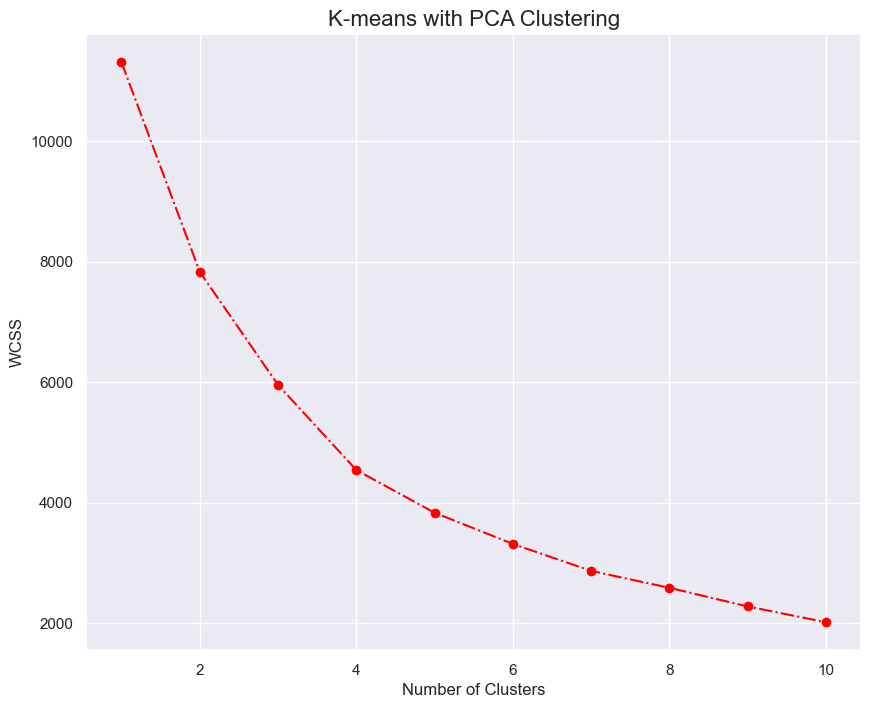

In [460]:
# Plot the Within Cluster Sum of Squares for the K-means PCA model. Here we make a decission about the number of clusters.
# Again it looks like four is the best option.
plt.figure(figsize = (10,8))
plt.plot(range(1, 11), wcss, marker = 'o', linestyle = '-.',color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-means with PCA Clustering',fontsize = 16)
plt.show()

In [462]:
# We have chosen four clusters, so we run K-means with number of clusters equals four. 
# Same initializer and random state as before.
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 7)
# We fit our data with the k-means pca model
kmeans_pca.fit(scores_pca)

KMeans(n_clusters=4, random_state=7)

K-Means algorithm has learnt from our new components and created 4 clusters . I would like to see old datasets with new components and labels .

### K-Means clustering with PCA Results

In [465]:
# We create a new data frame with the original features and add the PCA scores and assigned clusters.
df_segm_pca_kmeans = pd.concat([df.reset_index(drop = True), pd.DataFrame(scores_pca)], axis = 1)
df_segm_pca_kmeans.columns.values[-3: ] = ['Component 1', 'Component 2', 'Component 3']
# The last column we add contains the pca k-means clustering labels.
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [467]:
df_segm_pca_kmeans.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,Segment K-means PCA
0,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,1
1,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,0
2,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,3
3,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,2
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,2


In [469]:
# We calculate the means by segments.
df_segm_pca_kmeans_freq = df_segm_pca_kmeans.groupby(['Segment K-means PCA']).mean()
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3
Segment K-means PCA,,,,,,,,,,
0,0.900576,0.963977,28.920749,1.061960,107571.126801,0.677233,0.439481,-1.106034,0.705300,-0.776925
1,0.503788,0.689394,55.689394,2.128788,158209.094697,1.125000,1.106061,1.697646,2.029427,0.841953
2,0.027444,0.168096,35.737564,0.734134,141525.826758,1.267581,1.480274,1.372663,-1.046172,-0.248046
3,0.305011,0.095861,35.315904,0.760349,93633.372549,0.250545,0.039216,-1.047610,-0.904856,1.005493


Above we see our data grouped by K-Means Segment. We can also convert segment numbers to the label and see the observation number and proportions of each segment by total observation.

In [480]:
# Calculate the size of each cluster and its proportion to the entire data set.
df_segm_pca_kmeans['N Obs'] = df_segm_pca_kmeans[['Segment K-means PCA','Sex']].groupby(['Segment K-means PCA']).count()
df_segm_pca_kmeans['Prop Obs'] = df_segm_pca_kmeans['N Obs'] / df_segm_pca_kmeans['N Obs'].sum()
df_segm_pca_kmeans_freq = df_segm_pca_kmeans.rename({0:'young&standard',
                         1:'old&rich',
                         2:'midage&fewer_opportunities',
                         3:'midage&career_focused'})
df_segm_pca_kmeans_freq

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Component 1,Component 2,Component 3,Segment K-means PCA,N Obs,Prop Obs
young&standard,0,0,67,2,124670,1,2,2.514746,0.834122,2.174806,1,694.0,0.3470
old&rich,1,1,22,1,150773,1,2,0.344935,0.598146,-2.211603,0,264.0,0.1320
midage&fewer_opportunities,0,0,49,1,89210,0,0,-0.651063,-0.680093,2.280419,3,583.0,0.2915
midage&career_focused,0,0,45,1,171565,1,1,1.714316,-0.579927,0.730731,2,459.0,0.2295
4,0,0,53,1,149031,1,1,1.626745,-0.440496,1.244909,2,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1,0,47,1,123525,0,0,-0.866034,0.298330,1.438958,3,NaN,NaN
1996,1,1,27,1,117744,1,0,-1.114957,0.794727,-1.079871,0,NaN,NaN
1997,0,0,31,0,86400,0,0,-1.452298,-2.235937,0.896571,3,NaN,NaN
1998,1,1,24,1,97968,0,0,-2.241453,0.627108,-0.530456,0,NaN,NaN


In [484]:
df_segm_pca_kmeans['Legend'] = df_segm_pca_kmeans['Segment K-means PCA'].map({0:'young&standard',
                         1:'old&rich',
                         2:'midage&fewer_opportunities',
                         3:'midage&career_focused'})

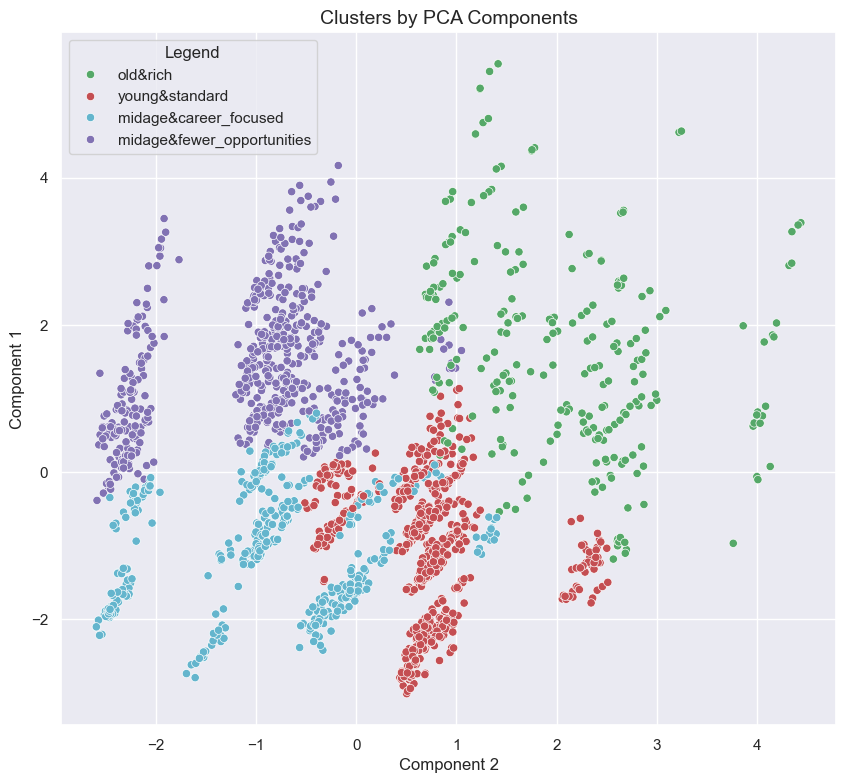

In [491]:
# Plot data by PCA components. The Y axis is the first component, X axis is the second.
x_axis = df_segm_pca_kmeans['Component 2']
y_axis = df_segm_pca_kmeans['Component 1']
plt.figure(figsize = (10,9))
sns.scatterplot(data=df_segm_pca_kmeans,x=x_axis, y=y_axis, hue = df_segm_pca_kmeans['Legend'], palette = ['g', 'r', 'c', 'm'])
plt.title('Clusters by PCA Components',fontsize=14)
plt.show()

When we plotted the K means clustering solution without PCA, we were only able to distinguish the green segment, but the division based on the components is much more pronounced.

That was one of the biggest goals of PCA to reduce the number of variables by combining them into bigger one

Conclusion
We segmented our customers into 4 groups. We are ready to start to choose our groups based on our aims and marketing them!

Segmentation helps marketers to be more efficient in terms of time, money and other resources.

They gain a better understanding of customer's needs and wants and therefore can tailor campaigns to customer segments most likely to purchase products.s.